In [1]:
import os

In [2]:
%pwd

'c:\\Users\\rahul\\Desktop\\Sem3\\Pneumonia_detection_cnn\\research'

In [3]:
# Changing the working directory
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\rahul\\Desktop\\Sem3\\Pneumonia_detection_cnn'

# Data Selection

For this project we have choose, Chest X-Ray Images (Pneumonia) data from the Kaggle.

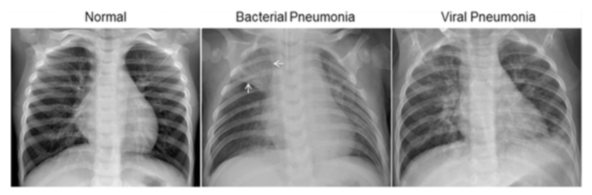

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse "interstitial" pattern in both lungs.

### Downloading the dataset from the kaggle using the `Kagglehub`.

In [5]:
import kagglehub

c:\Users\rahul\Desktop\Sem3\Pneumonia_detection_cnn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:43<00:00, 56.3MB/s]

Extracting files...


Path to dataset files: C:\Users\rahul\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


When we use the kagglehub, the dataset is downloaded at a cache path. That's why we moved the dataset to out working directory using the `shutil` package.

In [7]:
import shutil
from pathlib import Path

In [8]:
dst_path = Path("Data/raw_data")

os.makedirs(dst_path, exist_ok = True)

shutil.move(src = path,
            dst = dst_path)

'Data\\raw_data\\2'

# Data Cleaning

Checking the Image Shape.

In [10]:
from PIL import Image

In [14]:
img = Image.open(Path("Data/raw_data/2/chest_xray/train/NORMAL/IM-0210-0001.jpeg"))
print(img.size)

(1688, 1105)


Calling the Dataset.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

For training dataset.

Aplying the augmentation on the dataset. Also, the augmentation is always applied on the training dataset

| Parameter            | Description                     |
|----------------------|---------------------------------|
| `rotation_range`     | Rotate image (degrees)          |
| `width_shift_range`  | Shift horizontally              |
| `height_shift_range` | Shift vertically                |
| `shear_range`        | Shearing transformations        |
| `zoom_range`         | Zoom in/out                     |
| `horizontal_flip`    | Flip image horizontally         |
| `fill_mode`          | Fill in new pixels after transform |

In [19]:
# Create an instance of the generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    shear_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest"
)

# Load images from the directory
train_generator = train_datagen.flow_from_directory(
    directory = Path("Data/raw_data/2/chest_xray/train"),
    target_size = (1_000, 1_000),
    batch_size = 32,
    class_mode = "categorical"
)

Found 5216 images belonging to 2 classes.


For Validation dataset

In [20]:
val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
    directory = Path("Data/raw_data/2/chest_xray/val"),
    target_size = (1_000, 1_000),
    batch_size = 32,
    class_mode = "categorical"
)

Found 16 images belonging to 2 classes.


For Testing Dataset

In [21]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory = Path("Data/raw_data/2/chest_xray/test"),
    target_size = (1_000, 1_000),
    batch_size = 32,
    class_mode = "categorical"
)

Found 624 images belonging to 2 classes.


Now, checking the class distribution in the training dataset.

In [23]:
from collections import Counter

In [27]:
def print_class_distribution(directory):

    class_counts = {}
    
    for folder in os.listdir(directory):
        class_path = os.path.join(directory, folder)
        
        if os.path.isdir(class_path):
            class_counts[folder] = len(os.listdir(class_path))
    
    print(Counter(class_counts))

    return Counter(class_counts)

In [28]:
counts = print_class_distribution(Path("Data/raw_data/2/chest_xray/train"))

Counter({'PNEUMONIA': 3875, 'NORMAL': 1341})


It can be seen that the class imbalance is great in the dataset. We applied `class_weight` in model training which tells the model to "pay more attention" to the minority class by assigning weights.

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [30]:
classes = ["NORMAL", "PNEUMONIA"]
class_indices = {"NORMAL": 0, "PNEUMONIA": 1}
y = [class_indices["PNEUMONIA"]] * counts.get("PNEUMONIA") + [class_indices["NORMAL"]] * counts.get("NORMAL")

In [ ]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y), y = y)

class_weights = {i: weights[i] for i in range(len(weights))}

print(class_weights)

{0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}
